In [24]:
# import requests
# import os

# # 모델의 raw URL을 사용합니다.
# url = 'https://github.com/NostalgicJ/Quantum_2023/raw/test/RNN_Practice/10/saved_models/NVspin_SimpleRNN_model.h5'
# response = requests.get(url, allow_redirects=True)

# # 현재 코드 파일이 위치한 디렉토리의 상위 디렉토리로 이동
# parent_directory = os.path.join(os.getcwd(), '..')

# # 상위 디렉토리에 새로운 디렉토리 생성
# new_directory = os.path.join(parent_directory, 'using_models')

# if not os.path.exists(new_directory):
#     os.makedirs(new_directory)

# # 모델 저장하기
# with open('../using_models/NVspin_SimpleRNN_model.h5', 'wb') as f:
#     f.write(response.content)
    

In [25]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_models/NVspin_GRU_model_cuda_LearningRate.h5')

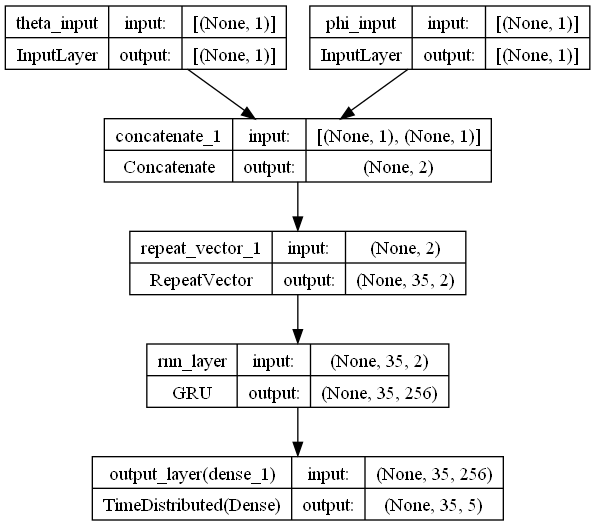

In [26]:
from tensorflow.keras.utils import plot_model
import os

# 저장할 디렉토리 생성
model_dir = 'model_plot'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 원하는 디렉토리 지정
file_name = 'GRU_model_plot.png'
full_path = os.path.join(model_dir, file_name)

# 모델 구조 시각화
plot_model(loaded_model, to_file=full_path, show_shapes=True, show_layer_names=True)


In [27]:
# import numpy as np

# # 새로운 theta와 phi 값 정의
# new_theta = np.array([np.pi/2]).reshape(-1, 1)  # 예시 값
# new_phi = np.array([np.pi]).reshape(-1, 1)    # 예시 값

# # 모델로 예측
# predicted_sequence = loaded_model.predict([new_theta, new_phi])

# # 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
# predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)
# print(predicted_sequence_indices[0])

In [28]:
import numpy as np
from scipy.linalg import expm, fractional_matrix_power
from math import *



# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])


# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)



# Initial state
init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave, init_wave.conj().T)
irho_mid = np.matrix(irho_init)

In [29]:
import os
from datetime import datetime
import pandas as pd

# 저장할 디렉토리 생성
result_dir = 'data_results'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# CSV file name setup
date = datetime.now()
printdate = date.strftime('%Y%m%d_%H%M%S')
filename = "/NVspin_GRU_data_random_results_" + printdate + '.csv'

# Create an empty DataFrame and write to CSV file
df = pd.DataFrame(columns=['Case', 'gate length', 'Theta', 'Phi', 'dt', 
                           'DL combination', 'DL fidelity', 'DL real time', 'DL computing time'])

df.to_csv(result_dir + filename, index=False)

In [30]:
import numpy as np
import random
import time
import pandas as pd


dt = 2.6

# 예측 수행
for i in range(1, 10001):
     
     theta = np.pi / 180 * random.uniform(0,180)
     phi = np.pi / 180 * random.uniform(0,360)
     
     target_theta = np.array(theta).reshape(-1, 1)
     target_phi = np.array(phi).reshape(-1, 1)
     
     start_time = time.time()
     
     predictions = loaded_model.predict([target_theta, target_phi])
     
     end_time = time.time()
     
     computing_time = round(end_time - start_time, 5)
     
     predicted_sequences = np.argmax(predictions, axis=-1)
     combination = predicted_sequences[0]
     
     # Target state
     # Theta must move first and then phi move.
     target_U = Rz(target_phi) @ Rx(target_theta) 
     irho_target = target_U @ irho_init @ target_U.conj().T

     fidelity = round(state_fidelity(irho_mid, irho_target), 5)
     
     print()
     print("------------------------------------------------")
     print("case :", i)
     print("theta :", theta)
     print("phi :", phi)
     print("combination :", combination)
     print("fidelity :", fidelity)
     print("computing_time :",computing_time)
     print("------------------------------------------------")
     print()
     
     output = [['case' + str(i), len(combination), theta, phi, dt, 
                    combination, fidelity, len(combination)*dt, computing_time]]
          
     # Create DataFrame and append to CSV file
     df = pd.DataFrame(output, columns=[ "Case", 'gate length', 'Theta', 'Phi', 'dt', 
                                        'DL combination', 'DL fidelity', 'DL real time', 'DL computing time'])
     
     df.to_csv(result_dir + filename, mode='a', header=False, index=False)

1/1 [==============================] - 0s 332ms/step

------------------------------------------------
case : 1
theta : 0.2687003309619101
phi : 3.2377303805290167
combination : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2]
fidelity : 0.98206
computing_time : 0.3968
------------------------------------------------

1/1 [==============================] - 0s 30ms/step

------------------------------------------------
case : 2
theta : 3.070355517631929
phi : 0.08905780111269707
combination : [0 0 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 1 1 1 3 3 3 2 2]
fidelity : 0.00127
computing_time : 0.10612
------------------------------------------------

1/1 [==============================] - 0s 23ms/step

------------------------------------------------
case : 3
theta : 2.9952784270196164
phi : 1.6535493162768264
combination : [0 0 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 2 4 4]
fidelity : 0.00534
computing_time : 0.06921
---------------------

In [35]:
my_df = pd.read_csv(result_dir + "/NVspin_GRU_data_random_results20230918_172606.csv")

my_df['DL fidelity'].mean()

0.50001136